In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import cv2
from scipy.ndimage.measurements import label
from lesson_functions import bin_spatial,color_hist

import time
%matplotlib inline

In [2]:
images_car= glob.glob('./vehicles/**/*.png')
images_noncar=glob.glob('./non-vehicles/**/*.png')
len(images_car),len(images_noncar)

(8792, 8968)

# Get HOG features from images

/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


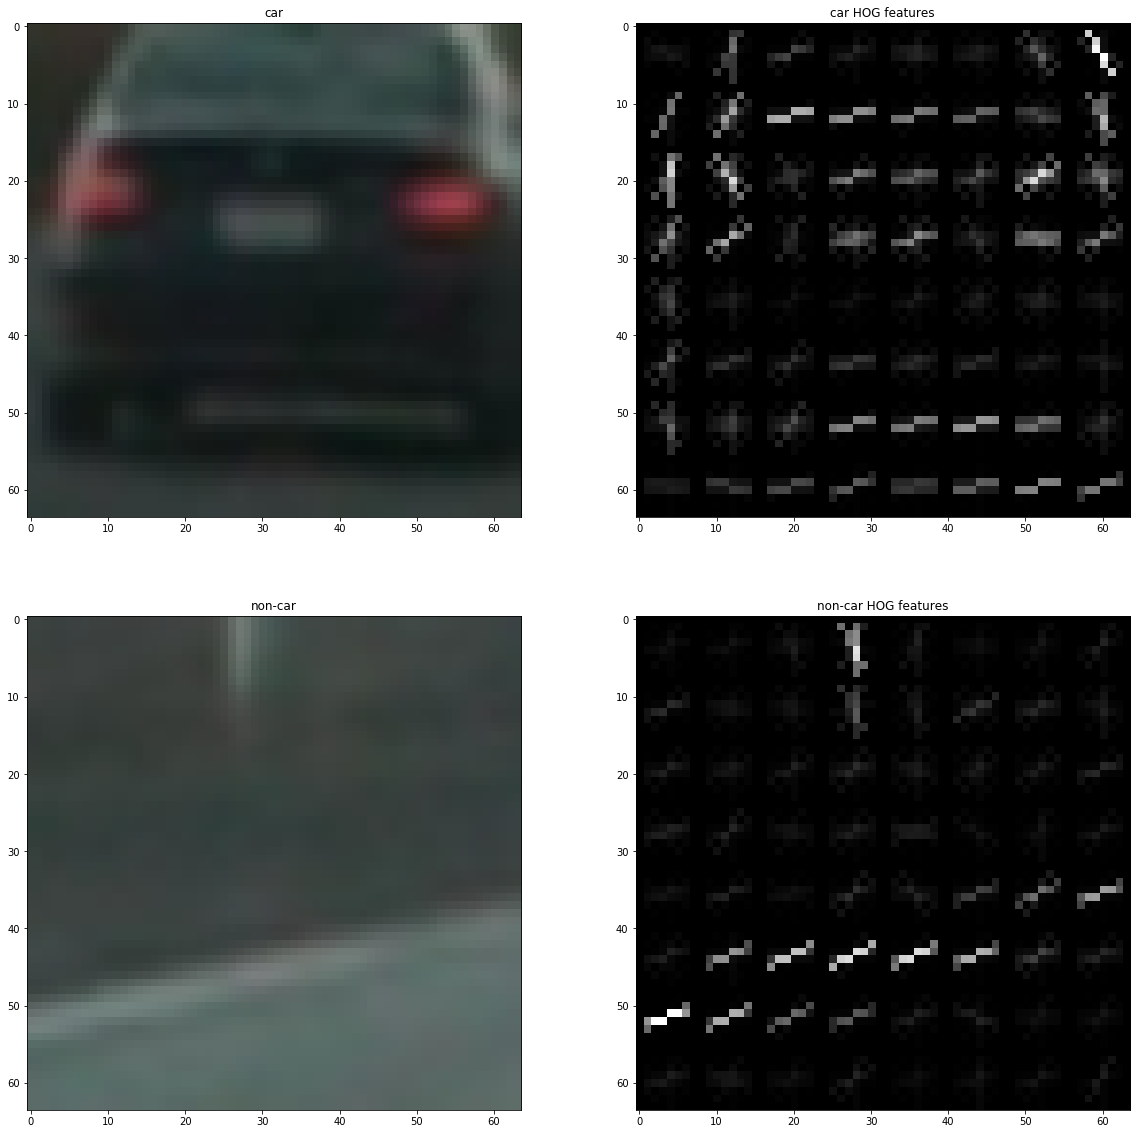

In [3]:
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#Visualize hog features
car = mpimg.imread(images_car[0])
non_car = mpimg.imread(images_noncar[0])
feat,hog_car_img = get_hog_features(car[:,:,0],9,8,2,vis=True)
feat,hog_noncar_img = get_hog_features(non_car[:,:,0],9,8,2,vis=True)
f,axes = plt.subplots(2,2,figsize=(20,20))
axes[0,0].imshow(car)
axes[0,0].set_title("car")
axes[0,1].imshow(hog_car_img,cmap='gray')
axes[0,1].set_title("car HOG features")
axes[1,0].imshow(non_car)
axes[1,0].set_title("non-car")
axes[1,1].imshow(hog_noncar_img,cmap='gray')
axes[1,1].set_title("non-car HOG features")

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(img, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,size=(16,16),hist_bins=32,hist_range=(0,256), img_arr=False):

    if img_arr:
        image = img
    else:
        image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)
    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    return np.concatenate((spatial_features, hist_features, hog_features))


### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
size = (16,16)
hist_bins=32
hist_range=(0,256)

t=time.time()
car_features = list(map(lambda x:extract_features(x,cspace=colorspace,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                                  hog_channel=hog_channel,size=size,hist_bins=hist_bins,hist_range=hist_range),images_car))
notcar_features= list(map(lambda x:extract_features(x,cspace=colorspace,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                                  hog_channel=hog_channel,size=size,hist_bins=hist_bins,hist_range=hist_range),images_noncar))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
X=X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    

# # Apply the scaler to X
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


119.29 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568


In [5]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

14.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9941
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00599 Seconds to predict 10 labels with SVC


# HOG Sub-Sampling Window Search

In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


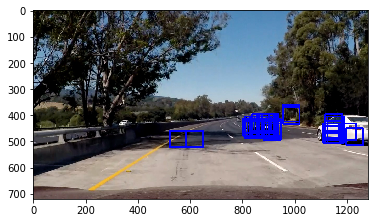

In [7]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):
    
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, cspace=colorspace, orient=orient,pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block, hog_channel=hog_channel, size=spatial_size,
                                    hist_bins=hist_bins,hist_range=hist_range,img_arr=True)
                             
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform((features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

images =glob.glob('./test_images/*.jpg')
image = images[1] #cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB)


# # Uncomment the following line if you extracted training
# # data from .png images (scaled 0 to 1 by mpimg) and the
# # image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[360,700], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       

window_img = draw_boxes(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB), hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)




In [8]:
window_images=[]
hot_windows=[]
for i in range(len(images)):
    print (i)
    img =mpimg.imread(images[i])
    draw_image = np.copy(img)
    image = images[i]
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[360,700], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))

    hot_window = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       

    window_img = draw_boxes(draw_image, hot_window, color=(0, 0, 255), thick=6)  
    hot_windows.append(hot_window)
    window_images.append(window_img)

0


/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1
2
3
4
5


#  Search and classify

Visualize the Search and classify results. We see that the prospective windows generated using Hog,histogram and spatial features always pick up the correct car pixels but also gives a lot of false positives and also Duplicate detections. We'll try to address this issue by using heat maps

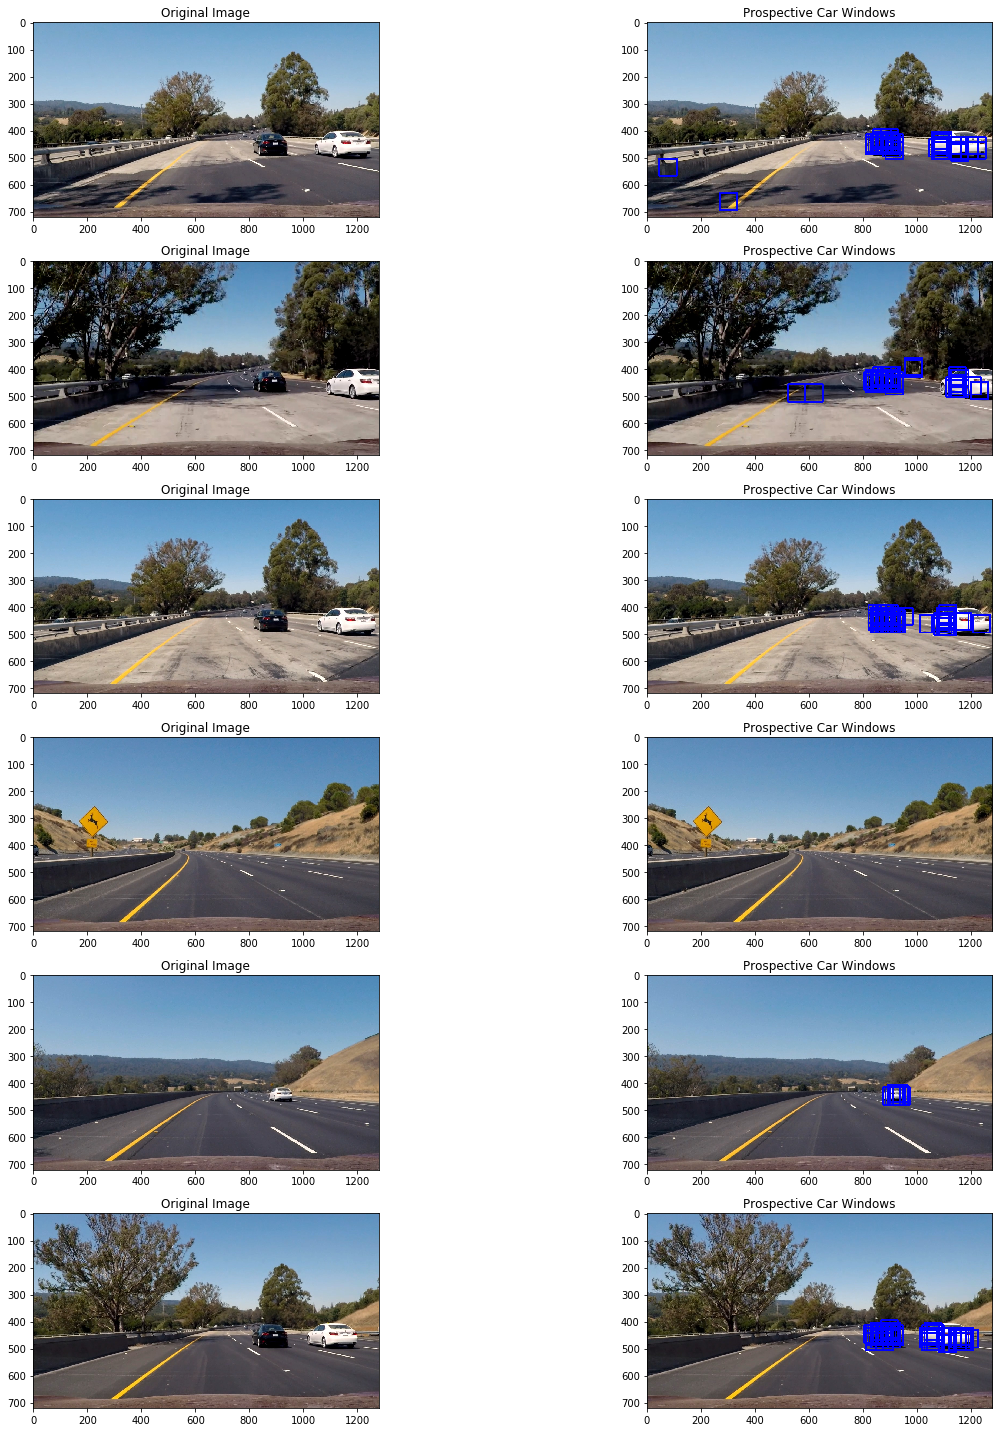

In [9]:
f , ax = plt.subplots(6,2,figsize=(20,20))
ax=ax.ravel()
j=0
for i in range(0,len(ax)):
    if i%2==0:
        ax[i].set_title('Original Image')
        ax[i].imshow(mpimg.imread(images[j]))
    else:
        ax[i].set_title('Prospective Car Windows')
        ax[i].imshow(window_images[j])        
        j=j+1
f.tight_layout()
plt.show()

# Heat Maps for Solving Multiple Detections and False Positives

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Visualize Heat Maps
We observe that using Heat Maps, most false positives are removed and also multiple detections are consolidated to one window per car.

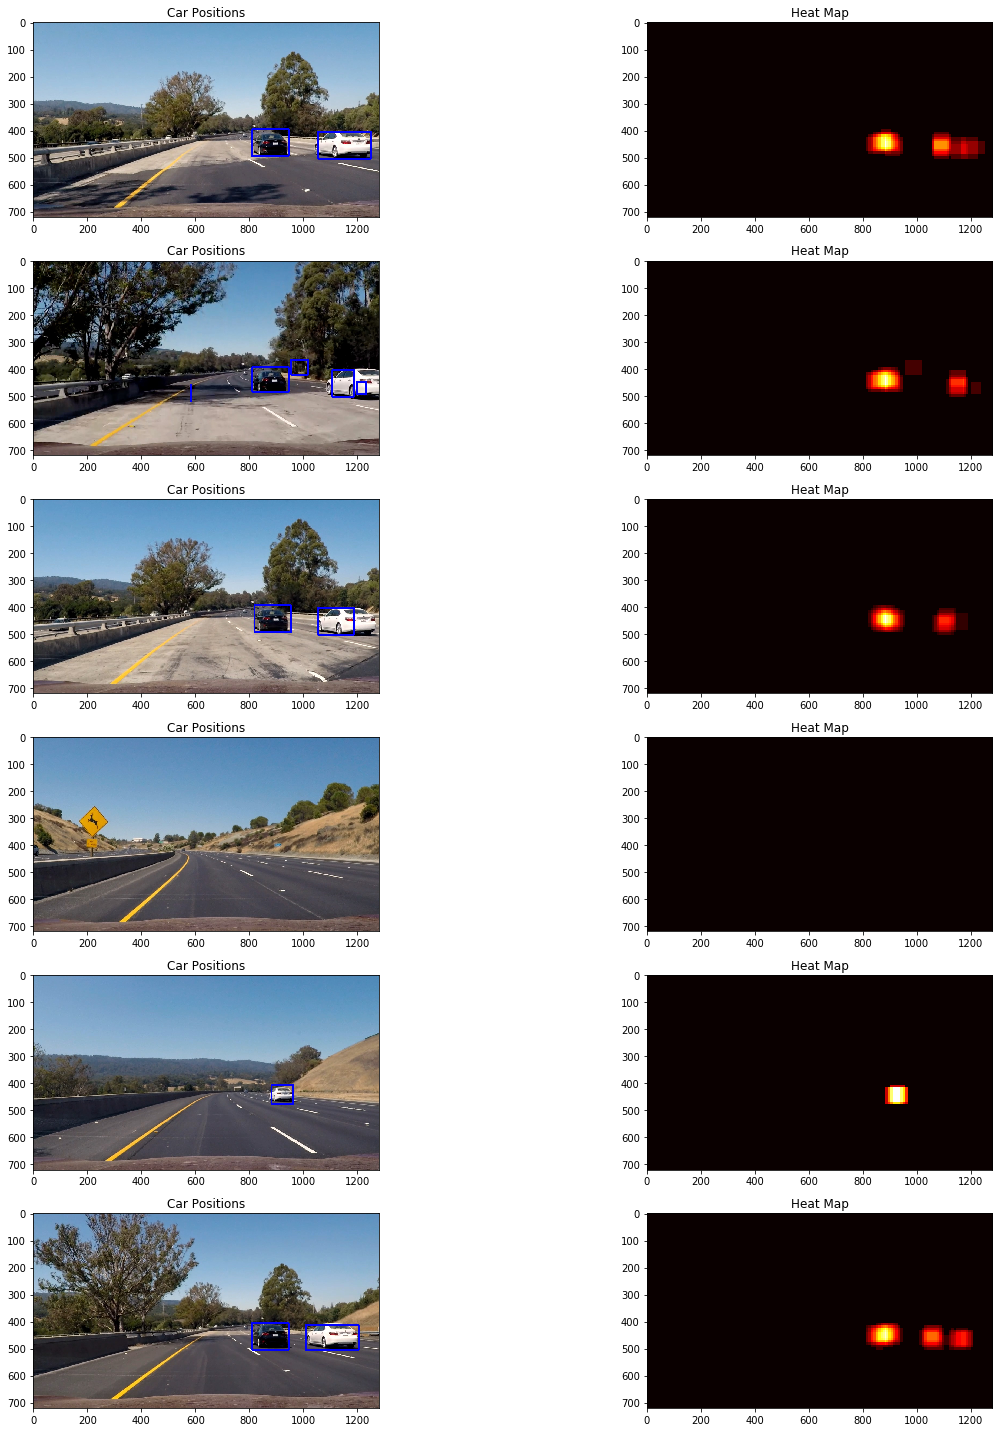

In [11]:
heatmaps=[]
draw_imgs=[]

for i in range(len(images)):
    image = mpimg.imread(images[i])
    heat =  np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows[i])

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmaps.append(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_imgs.append(draw_img)
    

f , ax = plt.subplots(6,2,figsize=(20,20))
ax=ax.ravel()
j=0
for i in range(0,len(ax)):
    if i%2==0:
        ax[i].set_title('Car Positions')
        ax[i].imshow(draw_imgs[j])
    else:
        ax[i].set_title('Heat Map')
        ax[i].imshow(heatmaps[j],cmap='hot')   
        j=j+1
f.tight_layout()
plt.show()


# Better HOG Sub-Sampling

In [12]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes=[]
    draw_img = np.copy(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    #img = img.astype(np.float32)/255
    
    ctrans_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  #2 Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step 
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step 
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, boxes
    
ystart = 360
ystop = 700
scale = 1.5
fast_hog_res=[]
fast_hog_windows=[]
for i in range (len(images)):
    img = cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB)
    out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, size, hist_bins)
    fast_hog_res.append(out_img)
    fast_hog_windows.append(boxes)


/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# Visualizing Results of Fast HOG

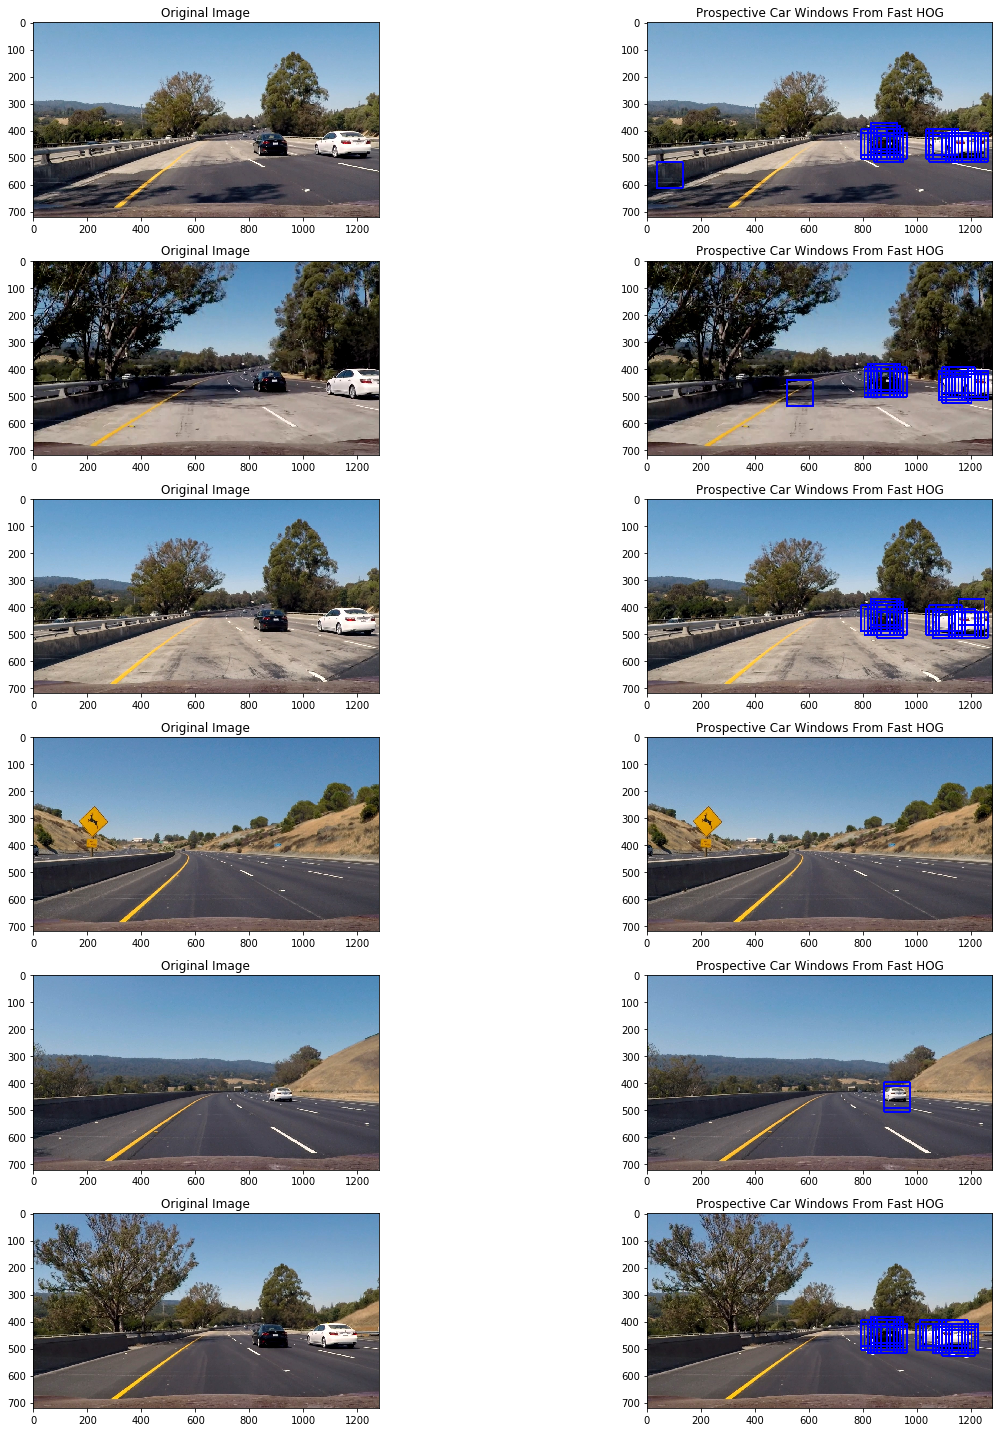

In [13]:
f , ax = plt.subplots(6,2,figsize=(20,20))
ax=ax.ravel()
j=0
for i in range(0,len(ax)):
    if i%2==0:
        ax[i].set_title('Original Image')
        ax[i].imshow(mpimg.imread(images[j]))
    else:
        ax[i].set_title('Prospective Car Windows From Fast HOG')
        ax[i].imshow(fast_hog_res[j])        
        j=j+1
f.tight_layout()
plt.show()

Using heatmaps again to deal with false positives

In [14]:
def apply_heatmap(img, windows):
    image = img
    heat =  np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img


# Visualize Fast HOG and Heatmaps in action

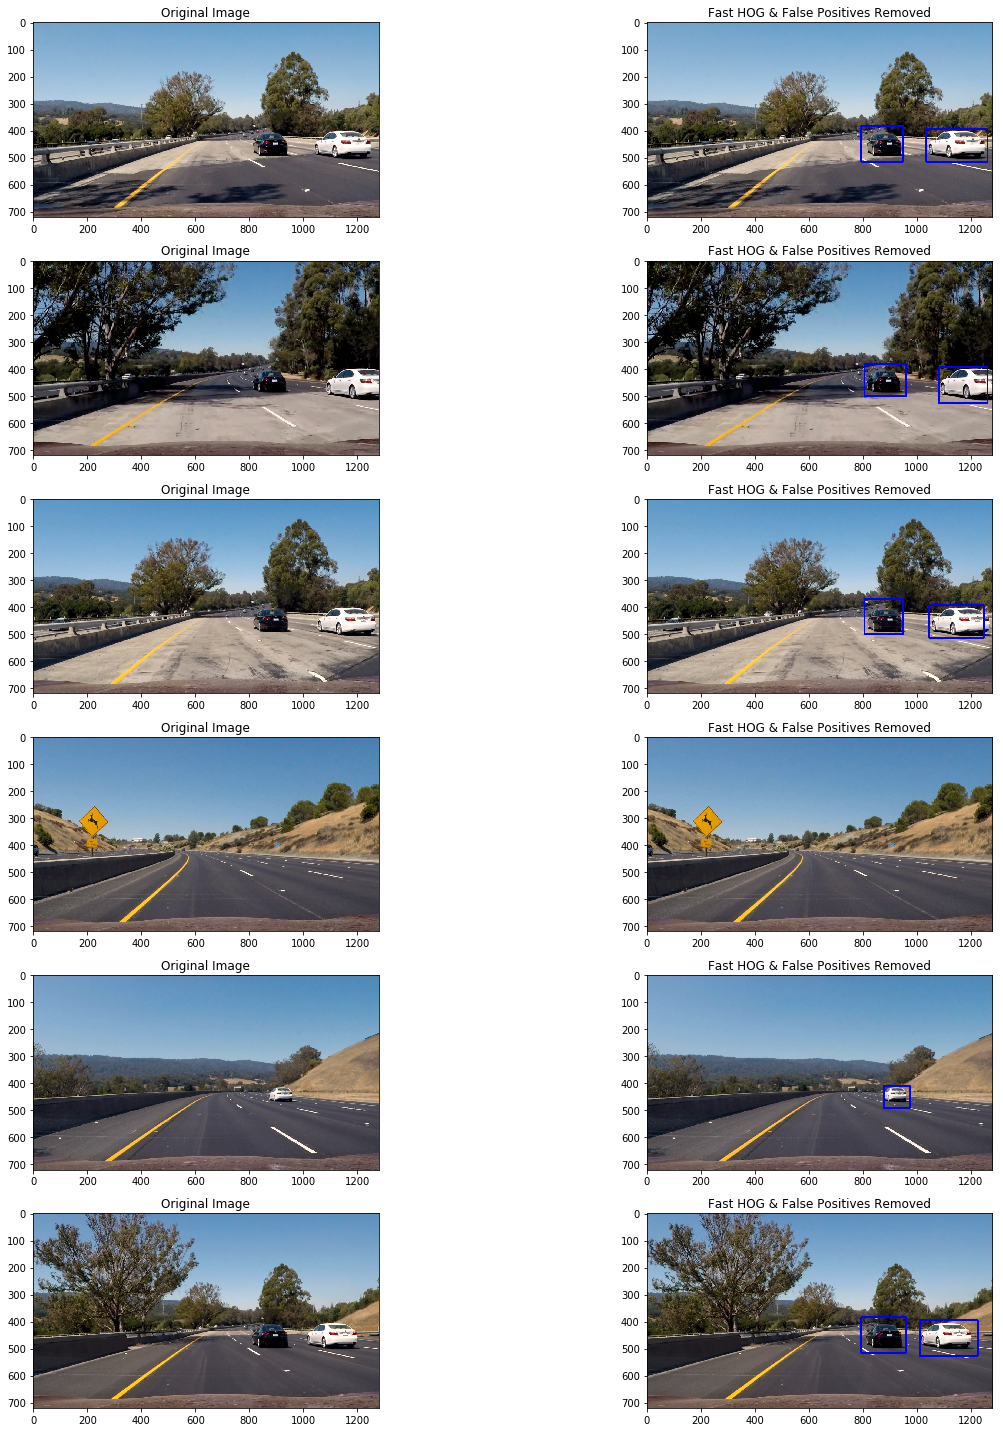

In [15]:
results=[]
for i in range(len(images)):
    img =  cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB)
    res = apply_heatmap(img, fast_hog_windows[i])
    results.append(res)
    
f , ax = plt.subplots(6,2,figsize=(20,20))
ax=ax.ravel()
j=0
for i in range(0,len(ax)):
    if i%2==0:
        ax[i].set_title('Original Image')
        ax[i].imshow(mpimg.imread(images[j]))
    else:
        ax[i].set_title('Fast HOG & False Positives Removed')
        ax[i].imshow(results[j])        
        j=j+1
f.tight_layout()
plt.show()

# Video Processing
The output of fast hog plus removing false positives and solving multiple detection problem using heat maps look pretty good so we can move on to car detection in the video stream

In [ ]:
from moviepy.editor import VideoFileClip
from functools import reduce

In [ ]:

class Storage():
    def __init__(self):
        self.frames=[]

def processVideo(thresh):
    frames= Storage()
    
    def pipeline(image):
        windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, size, hist_bins)
        heatmap = add_heat(np.zeros(image.shape),windows[1])
        if len(frames.frames)>=3:
            frames.frames = frames.frames[1:]
            
        frames.frames.append(heatmap)
        #Average out all 'frames' in frames.frames
        avg_heat = reduce(lambda x,y: x+y, frames.frames)/3
        thresh_avg_heatmap = apply_threshold(avg_heat,thresh)
        labels = label(thresh_avg_heatmap)
        return draw_labeled_bboxes(np.copy(image), labels)
    
    input_vid = VideoFileClip('project_video.mp4')
    res_vid = input_vid.fl_image(pipeline)
    res_vid.write_videofile('./result_video.mp4')

processVideo(1)
        